In [7]:
"""
02_model_training_and_validation.ipynb

Purpose
-------
This notebook trains and evaluates lasso-regularized logistic regression models
on the cleaned SECOM dataset. The goal here is not to build a highly optimized
predictive model, but to use logistic regression as an interpretable baseline
for identifying process variables associated with manufacturing failures.

Inputs
------
- X_train.csv, y_train.csv
- X_val.csv, y_val.csv
- X_test.csv, y_test.csv
(loaded from ../data/cleaned)

Outputs
-------
- precision_recall_curves_validation_set.png
- precision_recall_curves_validation_tiny_C.png
- final_model_precision_recall_curve.png
- lasso_logreg_validation_summary.csv
(saved to ../results/figures and ../results/tables)

What is done in this notebook
-----------------------------
1. Perform exploratory PCA on the training data to inspect the variance structure
   of the cleaned feature space. PCA is used only for exploration and is not used
   for dimensionality reduction or modeling.
2. Fit lasso-regularized logistic regression models on the training set across a
   range of regularization strengths (C = 0.00001 to 1.0).
3. Evaluate model performance on the validation set using precision–recall
   curves, which are more appropriate than accuracy given the class imbalance.
4. Compare models across a range of regularization strengths using validation-set
    curves to guide selection of C, noting that performance
    differences across values are modest.
5. Fit a final model using the selected value (C = 0.0003) on the combined
   training and validation data.
6. Evaluate the final model once on the held-out test set and report the
   corresponding precision–recall curve.

Scope Notes
-----------
This notebook is limited to model training and evaluation. Feature interpretation
and expanded association analysis are handled in a subsequent notebook. Given the
high-dimensional, noisy nature of the SECOM dataset, modest predictive performance
is expected and does not undermine the usefulness of the model for association
analysis.
"""

'\n02_model_training_and_validation.ipynb\n\nPurpose\n-------\nThis notebook trains and evaluates lasso-regularized logistic regression models\non the cleaned SECOM dataset. The goal here is not to build a highly optimized\npredictive model, but to use logistic regression as an interpretable baseline\nfor identifying process variables associated with manufacturing failures.\n\nInputs\n------\n- X_train.csv, y_train.csv\n- X_val.csv, y_val.csv\n- X_test.csv, y_test.csv\n(loaded from ../data/cleaned)\n\nOutputs\n-------\n- precision_recall_curves_validation_set.png\n- precision_recall_curves_validation_tiny_C.png\n- final_model_precision_recall_curve.png\n- lasso_logreg_validation_summary.csv\n(saved to ../results/figures and ../results/tables)\n\nWhat is done in this notebook\n-----------------------------\n1. Perform exploratory PCA on the training data to inspect the variance structure\n   of the cleaned feature space. PCA is used only for exploration and is not used\n   for dimension

## Visualize Data before Modelling

### Perform principal component analysis
In this step, in order to visualize our high dimensional data to get a better sense of if there are strong linear trends in the data, principal component analysis is performed. This will help use guide which model choices may be appropriate. 

Number of components explaining ≥80% variance: 85


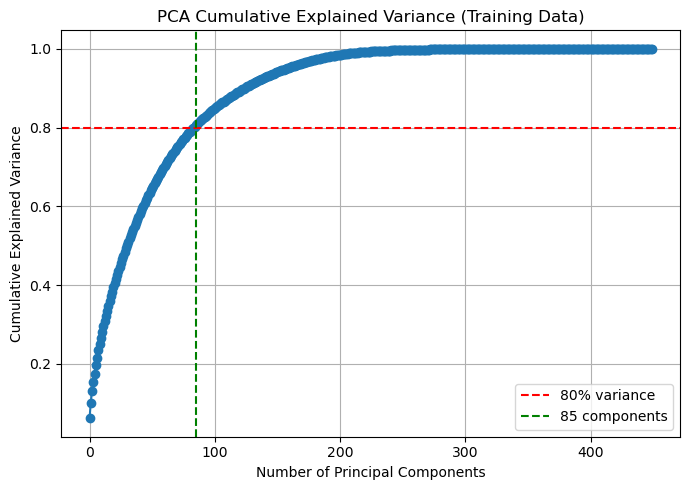

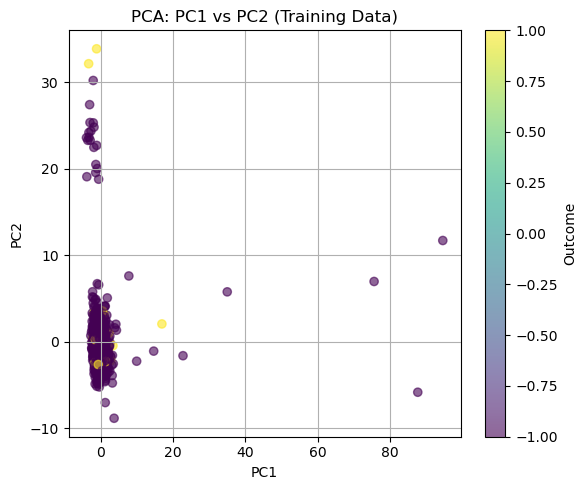

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --------------------------------
# Load cleaned data
# --------------------------------
DATA_DIR = "../data/cleaned"

X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")

# Convert y to 1D array for plotting
y_train_array = y_train["outcome"].values

# --------------------------------
# Standardize features (TRAIN ONLY)
# --------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --------------------------------
# Fit PCA (exploratory only)
# --------------------------------
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Number of components needed for 80% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components explaining ≥80% variance: {n_components_80}")

# --------------------------------
# Scree plot (SAVE THIS ONE)
# --------------------------------
plt.figure(figsize=(7, 5))
plt.plot(cumulative_variance, marker="o")
plt.axhline(0.80, color="red", linestyle="--", label="80% variance")
plt.axvline(
    n_components_80,
    color="green",
    linestyle="--",
    label=f"{n_components_80} components"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance (Training Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------
# PC1 vs PC2 (exploratory only)
# --------------------------------
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train_array,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2 (Training Data)")
plt.colorbar(scatter, label="Outcome")
plt.grid(True)
plt.tight_layout()
plt.show()


### Comment on above principal component analysis
Eighty-eight principal components are required to explain 80% of the variance, indicating that variability is spread across many dimensions rather than dominated by a small number of factors. This suggests a high-dimensional feature space in which substantial information is distributed across many correlated process variables.

Given the goal of identifying which original process variables are associated with manufacturing failures, we do not apply dimensionality reduction prior to modeling. Reducing the data to a small number of principal components would replace the original features with latent combinations, making it difficult to interpret associations at the level of individual process variables. 

Instead, we use regularized logistic regression as an interpretable baseline model, allowing feature associations to be examined directly while controlling model complexity in a high-dimensional setting.

## Model Training and Validation

### Perform Logistic Regression with Lasso for feature selection
In this step, L1-regularized (LASSO) logistic regression is applied to the training set to perform embedded feature selection. Weighted logistic regression is used to deal with the class imbalance in the data. A small set of regularization strengths C_values = [0.001, 0.01, 0.1, 1] is explored to control model complexity and sparsity. The 4 models number of non-zero features with their names are reported in a csv. 

In [9]:
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# --------------------------------
# Configuration
# --------------------------------
DATA_DIR = "../data/cleaned"
TARGET_COL = "outcome"
C_values = [0.001, 0.01, 0.1, 1]
nonzero_threshold = 1e-5

# --------------------------------
# Load cleaned data
# --------------------------------
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")

# Convert labels to 1D integer array
y_train_array = y_train[TARGET_COL].astype(int).values

# --------------------------------
# Fit models and summarize sparsity
# --------------------------------
summary_rows = []
t0 = time.time()

for C in C_values:
    start = time.time()
    print(f"Fitting C={C} ...", flush=True)

    model = LogisticRegression(
        penalty="l1",
        solver="saga",
        C=C,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train_array)

    coef = model.coef_.ravel()
    num_nonzero = int(np.sum(np.abs(coef) > nonzero_threshold))

    elapsed = time.time() - start
    print(
        f"Done C={C}: {num_nonzero} non-zero (>|{nonzero_threshold}|) "
        f"| {elapsed:.1f}s",
        flush=True
    )

    summary_rows.append({
        "C": C,
        "num_nonzero_features": num_nonzero,
        "fit_seconds": elapsed
    })

total = time.time() - t0

summary_df = (
    pd.DataFrame(summary_rows)
      .sort_values("C")
      .reset_index(drop=True)
)

print(f"\nTotal time: {total:.1f}s")
summary_df


Fitting C=0.001 ...
Done C=0.001: 44 non-zero (>|1e-05|) | 1.7s
Fitting C=0.01 ...
Done C=0.01: 127 non-zero (>|1e-05|) | 1.9s
Fitting C=0.1 ...
Done C=0.1: 197 non-zero (>|1e-05|) | 2.0s
Fitting C=1 ...
Done C=1: 209 non-zero (>|1e-05|) | 2.1s

Total time: 7.7s


,C,num_nonzero_features,fit_seconds
0,0.001,44,1.690819
1,0.010,127,1.881287
2,0.100,197,2.011007
3,1.000,209,2.111488


### Evaluate the 4 models performances using precision-recall curve
In this step, the validation set is used to evaluate how the models perform. A precision-recall curve is chosen to evalute model performance because we have a large class imbalance in our data and the measure recall reveals if our scarce class is being handeled well or not. 

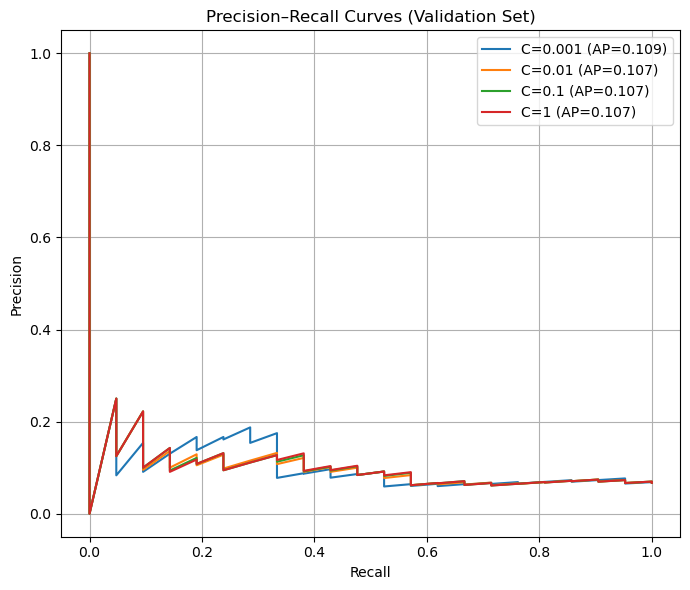

,C,average_precision,num_nonzero_features
0,0.001,0.108682,44
1,0.010,0.106528,127
2,0.100,0.106927,197
3,1.000,0.107127,209


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

# -----------------------------
# Settings
# -----------------------------
DATA_DIR = "../data/cleaned"
target_col = "outcome"
C_values = [0.001, 0.01, 0.1, 1]

nonzero_threshold = 1e-5  # avoid counting tiny numerical noise as "non-zero"

# -----------------------------
# Load train / val data
# -----------------------------
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")[target_col].astype(int).values

X_val = pd.read_csv(f"{DATA_DIR}/X_val.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val.csv")[target_col].astype(int).values

# If your labels are still -1/+1, convert to 0/1.
# If they are already 0/1, this leaves them unchanged.
y_train = (y_train == 1).astype(int)
y_val   = (y_val == 1).astype(int)

# Sanity checks
assert set(np.unique(y_train)).issubset({0, 1}), "Unexpected labels in y_train"
assert set(np.unique(y_val)).issubset({0, 1}), "Unexpected labels in y_val"
assert list(X_train.columns) == list(X_val.columns), "Train/val feature columns are misaligned"

# -----------------------------
# Fit models, compute PR data, and plot curves
# -----------------------------
plt.figure(figsize=(7, 6))

pr_summary_rows = []

for C in C_values:
    model = LogisticRegression(
        penalty="l1",
        solver="saga",
        C=C,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_val_probs = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
    ap = average_precision_score(y_val, y_val_probs)

    plt.plot(recall, precision, label=f"C={C} (AP={ap:.3f})")

    coef = model.coef_.ravel()
    num_nonzero = int(np.sum(np.abs(coef) > nonzero_threshold))

    pr_summary_rows.append({
        "C": C,
        "average_precision": float(ap),
        "num_nonzero_features": num_nonzero
    })

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Summary table (in-memory)
# -----------------------------
pr_summary_df = (
    pd.DataFrame(pr_summary_rows)
      .sort_values("C")
      .reset_index(drop=True)
)

pr_summary_df


### Fit models with smaller values of C and inspect performance using precision-recall curves
The 4 models above have similar precision-recall curves. To find the c value in which the models performance drops more, smaller values of c are used to train more modles and their performances are inspected using a precision recall curve. 

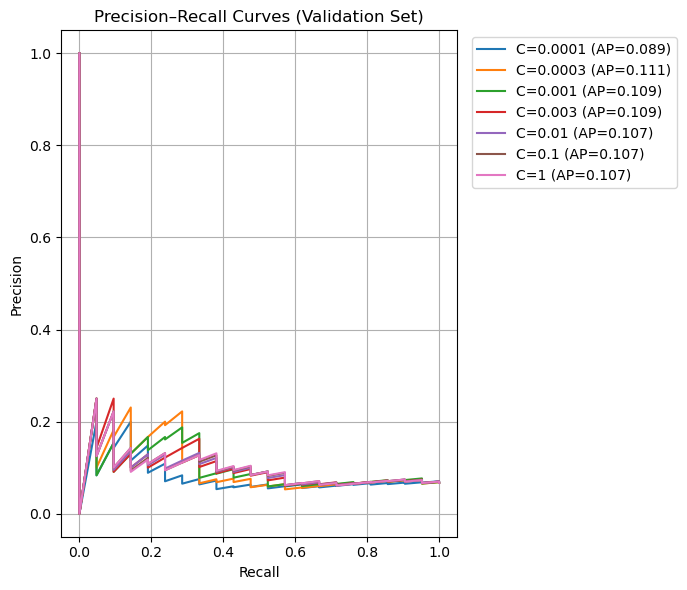

Saved figure: ../results/figures/precision_recall_curves_validation_set.png
Saved table: ../results/tables/lasso_logreg_validation_summary.csv


,C,num_nonzero_features,average_precision
0,0.0001,11,0.089321
1,0.0003,24,0.111290
2,0.0010,44,0.108682
3,0.0030,80,0.109084
4,0.0100,127,0.106528
5,0.1000,197,0.106927
6,1.0000,209,0.107127


In [11]:
# ============================================================
# EXTRA: explore smaller C values and save ONE PR curve figure
# + save summary table to results/tables
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

# -----------------------------
# Settings
# -----------------------------
DATA_DIR = "../data/cleaned"
target_col = "outcome"

C_values_base  = [0.001, 0.01, 0.1, 1]
C_values_small = [1e-4, 3e-4, 1e-3, 3e-3]
C_values_all   = sorted(set(C_values_base + C_values_small))

nonzero_threshold = 1e-5

# Output locations
fig_dir = "../results/figures"
table_dir = "../results/tables"
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(table_dir, exist_ok=True)

# -----------------------------
# Load train / validation data
# -----------------------------
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")[target_col].astype(int).values

X_val = pd.read_csv(f"{DATA_DIR}/X_val.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val.csv")[target_col].astype(int).values

# Ensure labels are 0/1
y_train = (y_train == 1).astype(int)
y_val   = (y_val == 1).astype(int)

# Sanity checks
assert list(X_train.columns) == list(X_val.columns)
assert set(np.unique(y_train)).issubset({0, 1})
assert set(np.unique(y_val)).issubset({0, 1})

# -----------------------------
# Fit models and plot PR curves
# -----------------------------
plt.figure(figsize=(7, 6))
summary_rows = []

for C in C_values_all:
    model = LogisticRegression(
        penalty="l1",
        solver="saga",
        C=C,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_val_probs = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
    ap = average_precision_score(y_val, y_val_probs)

    plt.plot(recall, precision, label=f"C={C:g} (AP={ap:.3f})")

    coef = model.coef_.ravel()
    num_nonzero = int(np.sum(np.abs(coef) > nonzero_threshold))

    summary_rows.append({
        "C": float(C),
        "num_nonzero_features": num_nonzero,
        "average_precision": float(ap)
    })

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Validation Set)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

# Save ONE figure
fig_path = f"{fig_dir}/precision_recall_curves_validation_set.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved figure: {fig_path}")

# -----------------------------
# Save summary table
# -----------------------------
summary_df = (
    pd.DataFrame(summary_rows)
      .sort_values("C")
      .reset_index(drop=True)
)

table_path = f"{table_dir}/lasso_logreg_validation_summary.csv"
summary_df.to_csv(table_path, index=False)

print(f"Saved table: {table_path}")
summary_df


### Inspect precision-recall curves for c = .00001, c = .0001, c = .0003, and c = .001  
The blue curve at c = .0001 and then orange curve c = .0003 appear visually to be the point at which performance drops. Another curve below will be created to inspect the blue and organge curves in isolation as well as a model with c = .00001.

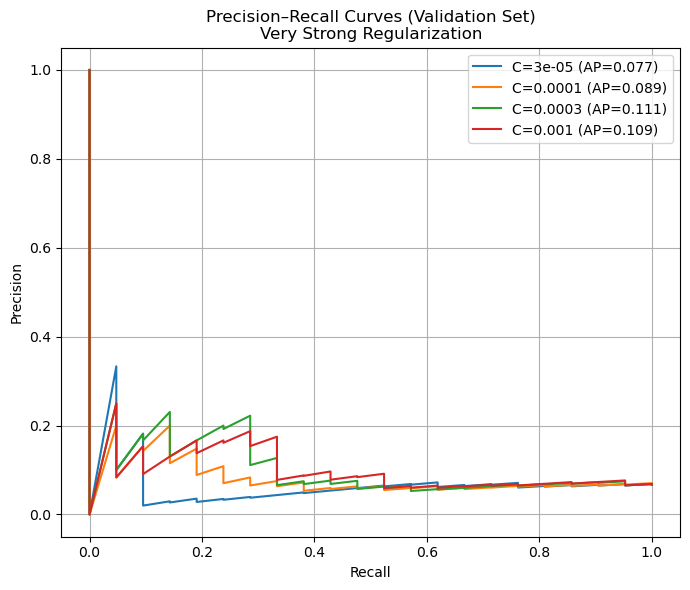

Saved figure: ../results/figures/precision_recall_curves_validation_tiny_C.png


In [12]:
# ============================================================
# PR curves for very small C values only
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

# -----------------------------
# Settings
# -----------------------------
DATA_DIR = "../data/cleaned"
target_col = "outcome"

# Very strong regularization values
C_values_tiny = [3e-5, 1e-4, 3e-4, 0.001]

fig_dir = "../results/figures"
os.makedirs(fig_dir, exist_ok=True)

# -----------------------------
# Load train / validation data
# -----------------------------
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")[target_col].astype(int).values

X_val = pd.read_csv(f"{DATA_DIR}/X_val.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val.csv")[target_col].astype(int).values

# Ensure labels are 0/1
y_train = (y_train == 1).astype(int)
y_val   = (y_val == 1).astype(int)

# Sanity checks
assert list(X_train.columns) == list(X_val.columns)
assert set(np.unique(y_train)).issubset({0, 1})
assert set(np.unique(y_val)).issubset({0, 1})

# -----------------------------
# Fit models and plot PR curves
# -----------------------------
plt.figure(figsize=(7, 6))

for C in C_values_tiny:
    model = LogisticRegression(
        penalty="l1",
        solver="saga",
        C=C,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_val_probs = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
    ap = average_precision_score(y_val, y_val_probs)

    plt.plot(recall, precision, label=f"C={C:g} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(
    "Precision–Recall Curves (Validation Set)\nVery Strong Regularization"
)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save ONE figure only
fig_path = f"{fig_dir}/precision_recall_curves_validation_tiny_C.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved figure: {fig_path}")


### Justification for choice of c = .0003
Visual inspection of the figure suggests that C = 0.0003 is the best choice among the values considered. Smaller values of C lead to worse average precision, and increasing C beyond 0.0003 also does not improve performance. While differences across C values are not large, C = 0.0003 achieves the highest average precision on the validation set. For this reason, C = 0.0003 is selected as the regularization parameter for the final model

## Fit final model using training and validation sets

### Use C = .0003 Logistic regression with Lasso and weighting for class imbalance 
In this step, the training and validation sets are combined to fit the final logistic regression model with L1 regularization and class weighting. Using both sets allows more information to be available when estimating the final model parameters, after the regularization strength has already been selected. The trained model is then evaluated once on the held-out test set to obtain the final precision–recall curve.

Saved final PR curve figure: ../results/figures/final_model_precision_recall_curve.png


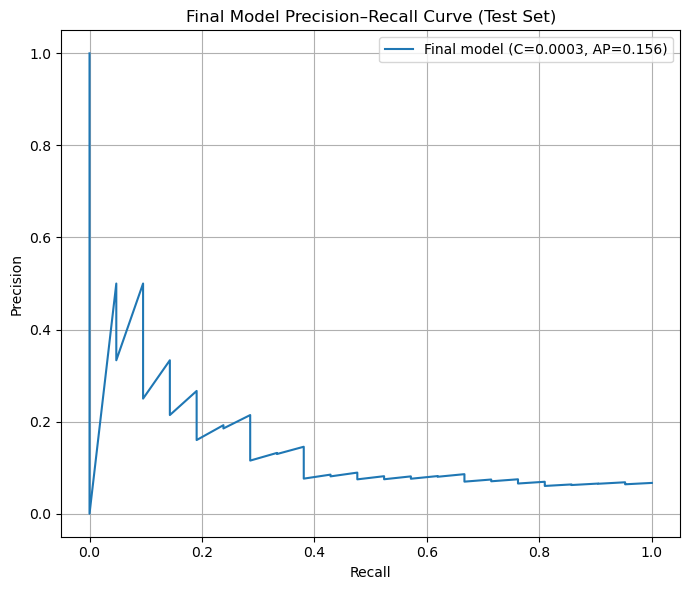

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

# -----------------------------
# Settings
# -----------------------------
DATA_DIR = "../data/cleaned"
target_col = "outcome"
C_final = 3e-4
nonzero_threshold = 1e-5

# -----------------------------
# Load cleaned data
# -----------------------------
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")[target_col].astype(int).values

X_val = pd.read_csv(f"{DATA_DIR}/X_val.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val.csv")[target_col].astype(int).values

X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")[target_col].astype(int).values

# Ensure labels are 0/1
y_train = (y_train == 1).astype(int)
y_val   = (y_val == 1).astype(int)
y_test  = (y_test == 1).astype(int)

# -----------------------------
# Combine train + validation
# -----------------------------
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val])

# Sanity check
assert list(X_trainval.columns) == list(X_test.columns), "Feature mismatch"

# -----------------------------
# Fit final model
# -----------------------------
final_model = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=C_final,
    class_weight="balanced",
    max_iter=5000,
    tol=1e-3,
    n_jobs=-1,
    random_state=42
)

final_model.fit(X_trainval, y_trainval)

# -----------------------------
# Test-set evaluation
# -----------------------------
test_probs = final_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, test_probs)
ap = average_precision_score(y_test, test_probs)

# -----------------------------
# Plot final PR curve (test set)
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(
    recall,
    precision,
    label=f"Final model (C={C_final}, AP={ap:.3f})"
)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Final Model Precision–Recall Curve (Test Set)")
ax.grid(True)
ax.legend()
fig.tight_layout()

# -----------------------------
# Save figure (before show)
# -----------------------------
out_dir = "../results/figures"
os.makedirs(out_dir, exist_ok=True)

fig_path = f"{out_dir}/final_model_precision_recall_curve.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"Saved final PR curve figure: {fig_path}")

plt.show()
